In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import tree

# Taken from Richard's "Reprod Figure 2"

In [3]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for idx, tree in enumerate(model): # RONAK EDIT
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        sampled_indices = model.estimators_samples_[idx]
        unsampled_indices = np.delete(np.arange(0, len(X)), sampled_indices)
        
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

/home/ronak/miniconda3/envs/uf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
def CART_estimate(X, y, n_trees = 300, bootstrap = True, depth = 30):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth, max_features = math.ceil(int(math.sqrt(X.shape[1]))))
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

## Simulate Data and Conditional Entropy Prediction

In [5]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

## Compute True Conditional Entropy

In [6]:
def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

## Conditional Entropy versus Sample Size

In [7]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu, algos):
        
    sample_sizes = pickle.load(open('sample_sizes_d_%d.pkl' % d, 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_n_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    result[:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
#     uf = pickle.load(open('uf_by_n_d_%d.pkl' % d, 'rb'))
#     cart = pickle.load(open('cart_by_n_d_%d.pkl' % d, 'rb'))
#     irf = pickle.load(open('irf_by_n_d_%d.pkl' % d, 'rb'))
#     uf2 = pickle.load(open('uf2_by_n_d_%d.pkl' % d, 'rb'))
#     uf2 = pickle.load(open('hon_by_n_d_%d.pkl' % d, 'rb'))
#     results = [cart, irf, uf, uf2, hon]
    
#     for j, algo in enumerate(algos):
#         # Plot the mean over trials as a solid line.
#         ax.plot(sample_sizes,
#                 np.mean(results[j], axis = 1).flatten(), 
#                 label = algo['label'], 
#                 linewidth = 4, 
#                 color = algo['color'])
#         # Use transparent lines to show other trials.
#         for t in range(num_plotted_trials):
#             ax.plot(sample_sizes, 
#                     results[j][:, t].flatten(),  
#                     linewidth = 2, 
#                     color = algo['color'],
#                     alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
            
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("Effect Size = %.1f, d = %d" % (mu, d))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

## Conditional Entropy Estimates versus Effect Size

In [8]:
def plot_cond_entropy_by_mu(ax, d, n, algos):
    
    mus = pickle.load(open('mus.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_mu_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(mus,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])

#     uf = pickle.load(open('uf_by_mu_d_%d.pkl' % d, 'rb'))
#     cart = pickle.load(open('cart_by_mu_d_%d.pkl' % d, 'rb'))
#     irf = pickle.load(open('irf_by_mu_d_%d.pkl' % d, 'rb'))
#     uf2 = pickle.load(open('uf2_by_mu_d_%d.pkl' % d, 'rb'))
#     hon = pickle.load(open('hon_by_mu_d_%d.pkl' % d, 'rb'))
#     results = [cart, irf, uf, uf2, hon]
        
#     for j, algo in enumerate(algos):
#         # Plot the mean over trials as a solid line.
#         ax.plot(mus, 
#                 np.mean(results[j], axis = 1).flatten(), 
#                 label = algo['label'], 
#                 linewidth = 4, 
#                 color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.set_ylim(ymin = -.05)
    ax.set_title("n = %d, d = %d" % (n, d))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [9]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1, effect_size, algos)
    plot_cond_entropy_by_n(axes[0, 1], num_plotted_trials, d2, effect_size, algos)
                                                  
    plot_cond_entropy_by_mu(axes[1, 0], d1, n1, algos)
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2, algos)
    
    axes[0,0].legend(loc = "upper left")
    
    plt.tight_layout()
    plt.savefig("fig2.pdf")
    plt.show()

In [10]:
def get_cond_entropy_vs_n(mean, d, num_trials, sample_sizes, algos):
    
    # labels = ["CART", "IRF", "UF1", "UF2", "UF3", "UF4", "UF5"]
    
    def worker(t):
        X, y = generate_data(elem, d, mu = mean)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(sample_sizes), num_trials))
    for i, elem in enumerate(sample_sizes):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
        
    pickle.dump(sample_sizes, open('sample_sizes_d_%d.pkl' % d, 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_n_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

In [11]:
def estimate_ce(X, y, label):
    if label == "CART":
        return CART_estimate(X, y)
    elif label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF1":
        return cef_estimate(np.array(X), y, 300, .32, depth = 30)
    elif label == "UF2":
        uf = UncertaintyForest(n_estimators = 300, frac_struct = 0.33, frac_est = 0.33)
        return uf.fit(X,y).estimate_cond_entropy()
    elif label == "UF3":
        uf = UncertaintyForest(n_estimators = 300, frac_struct = 0.33, frac_est = 0.33, finite_correction = False)
        return uf.fit(X,y).estimate_cond_entropy()
    elif label == "UF4":
        uf = UncertaintyForest(n_estimators = 300, frac_struct = 0.50, frac_est = 0.25)
        return uf.fit(X,y).estimate_cond_entropy()
    elif label == "UF5":
        uf = UncertaintyForest(n_estimators = 300, frac_struct = 0.25, frac_est = 0.50)
        return uf.fit(X,y).estimate_cond_entropy()
    else:
        raise ValueError("Unrecognized Label!")

In [12]:
def get_cond_entropy_vs_mu(n, d, num_trials, mus, algos):
    
    # labels = ["CART", "IRF", "UF1", "UF2", "UF3", "UF4", "UF5"]
    
    def worker(t):
        X, y = generate_data(n, d, mu = elem)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(mus), num_trials))
    for i, elem in enumerate(mus):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(mus, open('mus.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_mu_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

## Run Experiments and Plot

In [13]:
# Data.
mus = [i * 0.5 for i in range(1, 11)]
frac_eval = 0.3
effect_size = 1
d1 = 1
d2 = 40
n1 = 5000
n2 = 10000
num_trials = 20
num_plotted_trials = 10
sample_sizes_d1 = range(400, 2501, 300)
sample_sizes_d2 = range(400, 10001, 960)

# Fake params.
# mus = [i * 0.5 for i in range(1, 5)]
# # frac_eval = 0.3
# # n_estimators = 200
# effect_size = 1
# d1 = 1
# d2 = 3
# n1 = 100
# n2 = 110
# num_trials = 3
# num_plotted_trials = 3
# sample_sizes_d1 = range(100, 120, 10)
# sample_sizes_d2 = range(100, 130, 10)

# Algorithms.
algos = [
    {
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'label': 'UF1',
        'title': 'Uncertainty Forest 1',
        'color': "#F41711",
    },
    {
        'label': 'UF2',
        'title': 'Uncertainty Forest 2',
        'color': "purple",
    },
    {
        'label': 'UF3',
        'title': 'Uncertainty Forest 3',
        'color': "blue",
    },
    {
        'label': 'UF4',
        'title': 'Uncertainty Forest 4',
        'color': "m",
    },
    {
        'label': 'UF5',
        'title': 'Uncertainty Forest 5',
        'color': "g",
    },
]

### Estimated H(Y | X) versus n, d = 1

In [14]:
get_cond_entropy_vs_n(effect_size, d1, num_trials, sample_sizes_d1, algos)

array([[[0.11289175, 0.13249047, 0.10948898, ..., 0.14373801,
         0.14568321, 0.10350109],
        [0.12270729, 0.12018801, 0.14294025, ..., 0.12144231,
         0.14116619, 0.13280001],
        [0.14281053, 0.12137804, 0.14429083, ..., 0.14528434,
         0.14832397, 0.14062809],
        ...,
        [0.14008121, 0.13476747, 0.13857733, ..., 0.14756241,
         0.11869932, 0.15054079],
        [0.13677171, 0.13345801, 0.11117453, ..., 0.13740767,
         0.1448905 , 0.12526771],
        [0.124253  , 0.13870665, 0.14172389, ..., 0.15956996,
         0.1387364 , 0.12637135]],

       [[0.37749442, 0.44032247, 0.38577225, ..., 0.40694048,
         0.37459631, 0.39032495],
        [0.39774885, 0.40508851, 0.39113612, ..., 0.40887598,
         0.42640851, 0.38059563],
        [0.44510388, 0.40301422, 0.43125961, ..., 0.44283364,
         0.48460305, 0.45228495],
        ...,
        [0.40535551, 0.43568541, 0.43962786, ..., 0.43407545,
         0.38552815, 0.45271124],
        [0.4

### Estimated H(Y | X) versus mu, d = 1

In [15]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n1, d1, num_trials, mus, algos)

array([[[4.44887132e-01, 4.07264607e-01, 4.41989491e-01, ...,
         4.69875538e-01, 4.25639896e-01, 4.42056499e-01],
        [1.61697128e-01, 1.29169016e-01, 1.60683943e-01, ...,
         1.61382685e-01, 1.47565089e-01, 1.76834259e-01],
        [5.51636917e-02, 5.19971663e-02, 5.15837150e-02, ...,
         5.55298460e-02, 4.88687633e-02, 6.16417057e-02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.00087685e-05, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.33470465e-06, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.70488477e-05]],

       [[6.36976055e-01, 6.47602172e-01, 6.49754324e-01, ...,
         6.46055417e-01, 6.48344451e-01, 6.37699471e-01],
        [4.46293916e-01, 4.14947830e-01, 4.25739088e-01, ...,
         4.29071006e-01, 4.47840411e-01, 4.42657004e-01],
        [2.11970757e-01, 

### Estimated H(Y | X) versus n, d = 40

In [16]:
# Estimate conditional entropy vs n.
get_cond_entropy_vs_n(effect_size, d2, num_trials, sample_sizes_d2, algos)

array([[[0.27097861, 0.24707461, 0.23774346, ..., 0.25300237,
         0.25651833, 0.22182999],
        [0.18349981, 0.17870982, 0.18324748, ..., 0.16328077,
         0.17157129, 0.17074885],
        [0.15552743, 0.16252559, 0.17106677, ..., 0.1675479 ,
         0.17088174, 0.16054516],
        ...,
        [0.15507056, 0.13838582, 0.14265686, ..., 0.14707582,
         0.14725778, 0.14182751],
        [0.15037583, 0.14253484, 0.1449174 , ..., 0.15522602,
         0.13137152, 0.14114018],
        [0.14699078, 0.13948537, 0.14753956, ..., 0.14053891,
         0.150182  , 0.15091605]],

       [[0.40559856, 0.37586871, 0.33265717, ..., 0.37114712,
         0.3820915 , 0.35313738],
        [0.37355202, 0.34344147, 0.35893631, ..., 0.34014044,
         0.35544702, 0.36792079],
        [0.35571298, 0.36485021, 0.40911077, ..., 0.38124949,
         0.4082858 , 0.37989953],
        ...,
        [0.37766462, 0.37504931, 0.37148138, ..., 0.36782295,
         0.37750746, 0.38365074],
        [0.3

### Estimated H(Y | X) versus mu, d = 40

In [17]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n2, d2, num_trials, mus, algos)

array([[[3.24587892e-01, 3.24915181e-01, 3.33206547e-01, ...,
         3.43028648e-01, 3.21107465e-01, 3.24843807e-01],
        [1.42515160e-01, 1.44621796e-01, 1.42389884e-01, ...,
         1.37553544e-01, 1.49615514e-01, 1.43838611e-01],
        [5.01632433e-02, 5.25739735e-02, 4.67994532e-02, ...,
         5.01758081e-02, 4.76566353e-02, 5.38872168e-02],
        ...,
        [1.11033359e-03, 8.72185088e-04, 1.18513058e-03, ...,
         9.55692712e-04, 1.05427467e-03, 1.06180245e-03],
        [7.93231436e-04, 9.29772465e-04, 9.51596133e-04, ...,
         1.00466469e-03, 1.09316157e-03, 1.05778119e-03],
        [8.84721772e-04, 8.89594996e-04, 8.25556312e-04, ...,
         8.92991080e-04, 1.24940154e-03, 1.14201451e-03]],

       [[5.92454678e-01, 5.85892337e-01, 5.99674229e-01, ...,
         6.02308782e-01, 5.95306413e-01, 5.90412309e-01],
        [3.59207378e-01, 3.66141583e-01, 3.70588366e-01, ...,
         3.77384325e-01, 3.68610493e-01, 3.69486269e-01],
        [1.79343886e-01, 

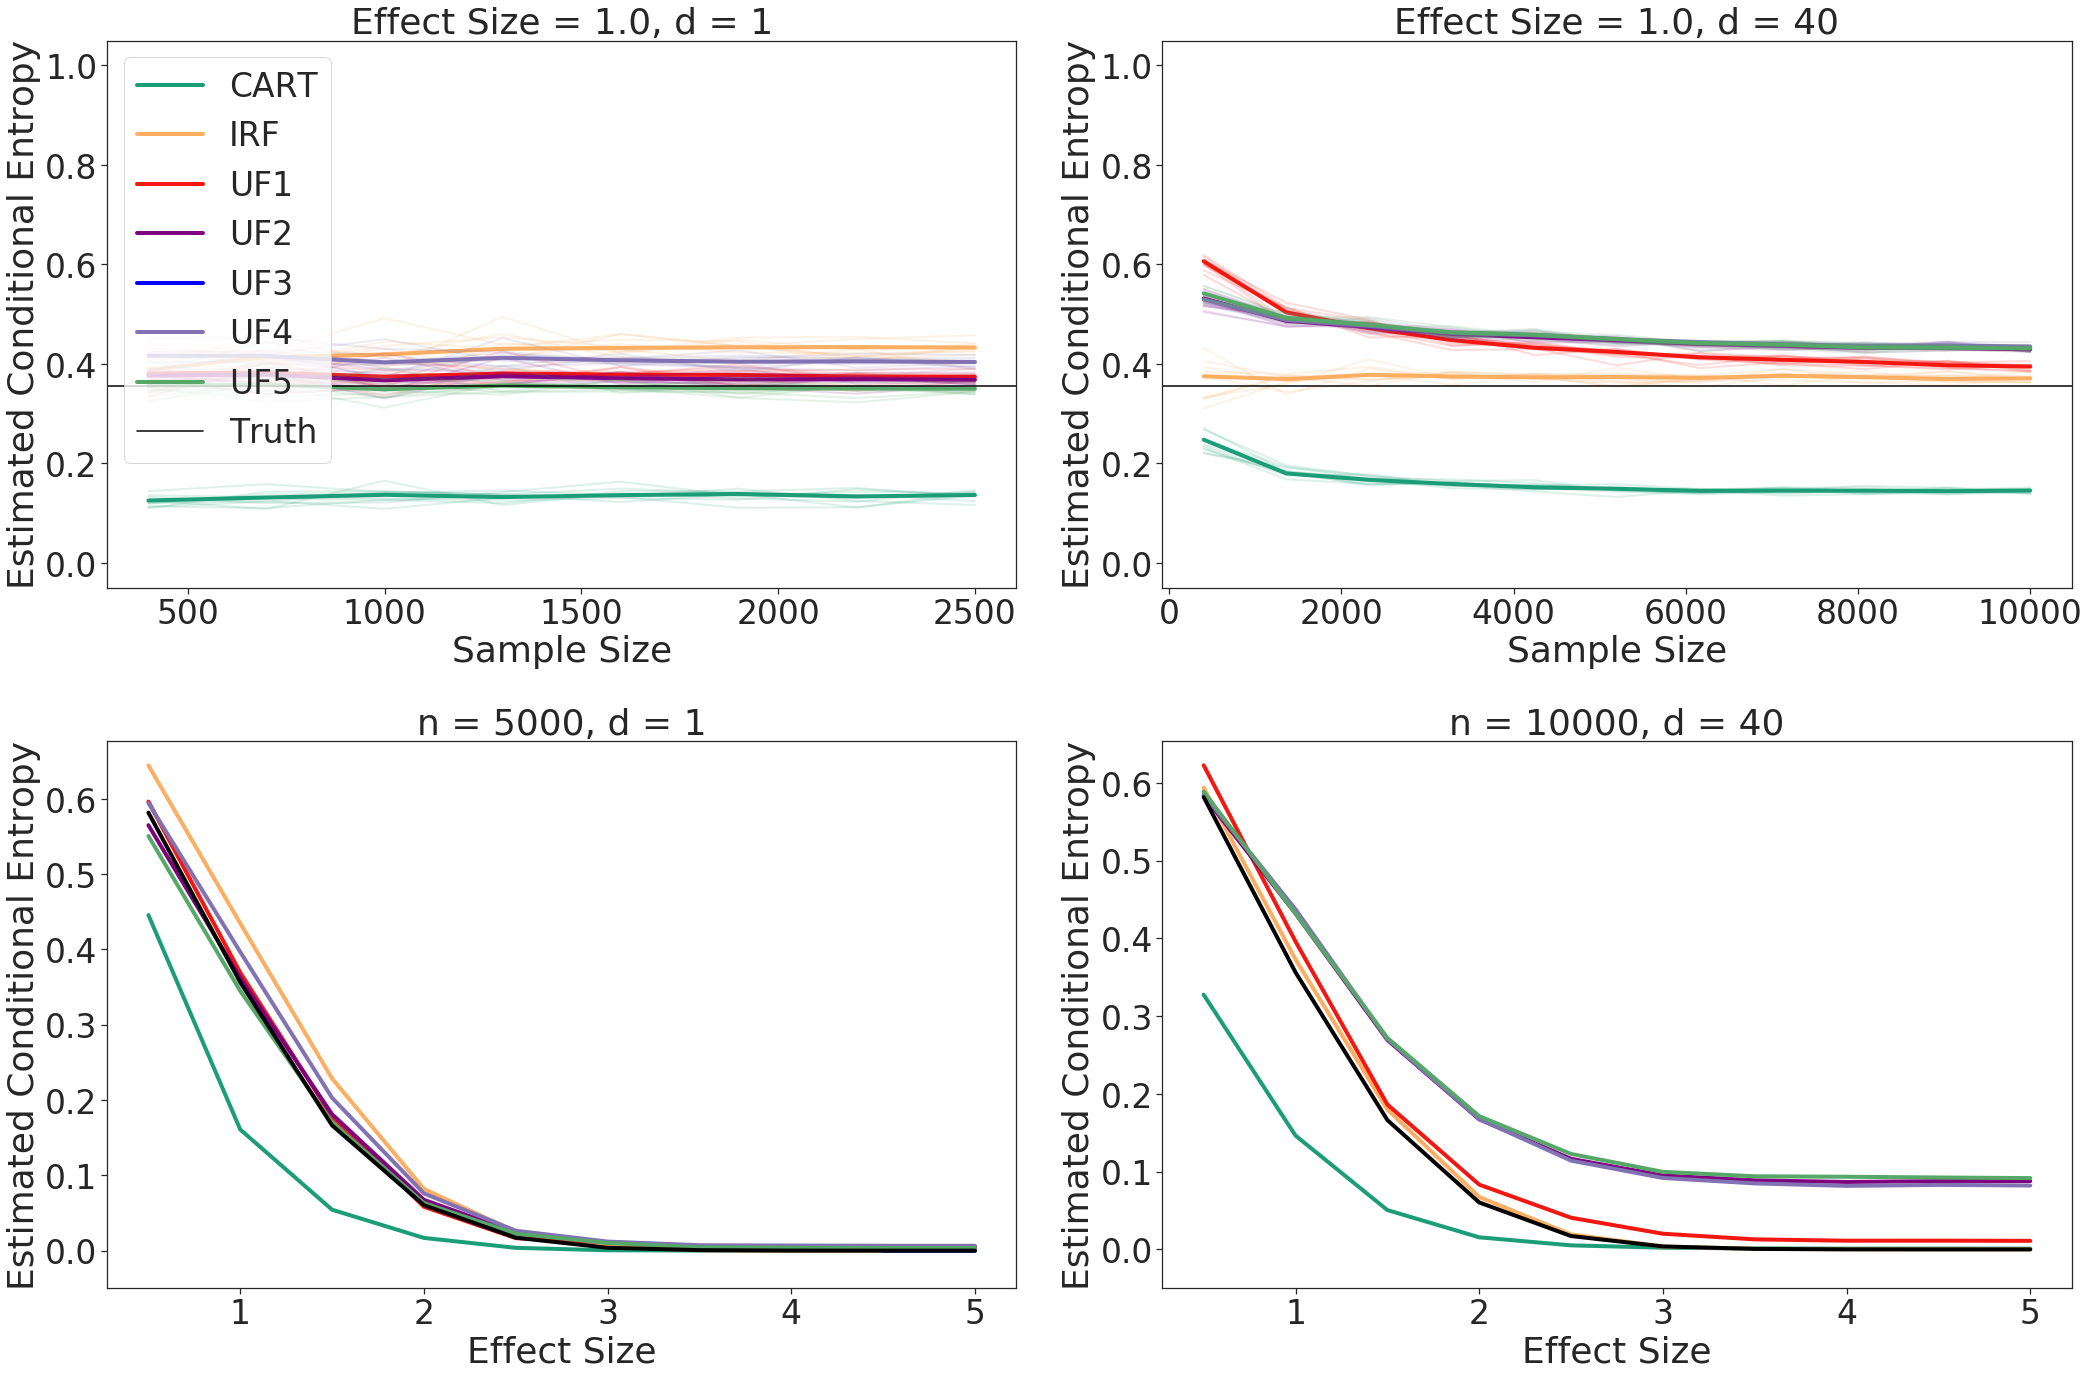

In [18]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos)